# Credit Card Fraud Detection

### Problem Statement

Credit card companies need to recognize fraudulent credit card transactions so that customers are not charged for items they did not purchase. 

Given a set of anonymized features for credit card transactions, identify the fraudulent ones. This is a logistic regression problem, however there is a class imbalance so we should use ROC-AUC. Confusion matrix accuracy is not meaningful for unbalanced classification.

### Accuracy Metric - ROC-AUC
The ROC (Receiver Operating Characteristics) AUC (Area Under the Curve) score is an evaluation metric for checking the classification's performance.

Basically, the ROC is a probability curve and the score is the area under this curve. The higher the area under the curve, the better the model is at correcting classifying examples.

### Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

### Data

You can download the data from [here](https://www.kaggle.com/mlg-ulb/creditcardfraud/home)

In [4]:
df = pd.read_csv('data/creditcard.csv')

In [9]:
print(df.columns.values)
print('Number of features: ' + str(len(df.columns.values)))

['Time' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10' 'V11' 'V12'
 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22' 'V23' 'V24'
 'V25' 'V26' 'V27' 'V28' 'Amount' 'Class']
Number of features: 31


The dataset contains 30 features. 28 of the features were anonymized using PCA. The remaining 3 features contain `Time`, `Amount`, and the final variable is `Class`, which is our output or response variable.

In [10]:
print("Total time spanning: {:.1f} days".format(df['Time'].max() / (3600 * 24.0)))
print("{:.3f} % of all transactions are fraud. ".format(np.sum(df['Class']) / df.shape[0] * 100))

Total time spanning: 2.0 days
0.173 % of all transactions are fraud. 


As mentioned above, the dataset is very unbalanced.

### Ideas for Feature Engineering for Credit Card Detection

In this dataset, we have anonymized PCA-transformed data. In the real world, however, we will only have access to features from credit card companies. What are some features that might be correlated with fraudlent or non-fraudlent cases?

- Transaction Identification Number
- Date and Time of the transaction
- Transaction Type (Internet, ATM, POS, ...)
- Entry Mode (Chip and pin, magnetic stripe, ...)
- Amount of the transaction
- Identification of the merchant type
- Merchant group identification
- Gender
- Age
- Bank
- Lcoation of transaction

From these, some secondary features can be created:

- time since the last transaction
- previous amount of the transaction
- previous country of the transaction

We can also use a transaction aggregating strategy. The derivation of the aggregation features consists in grouping the transactions made during the last given number of hours, first by card or account number, then by transaction type, merchant group, country or other, followed by calculating the number of transactions or the total amount spent on those transactions.

We can also create features using time, including day of the week, time (morning v. night), etc.

### Data Exploration

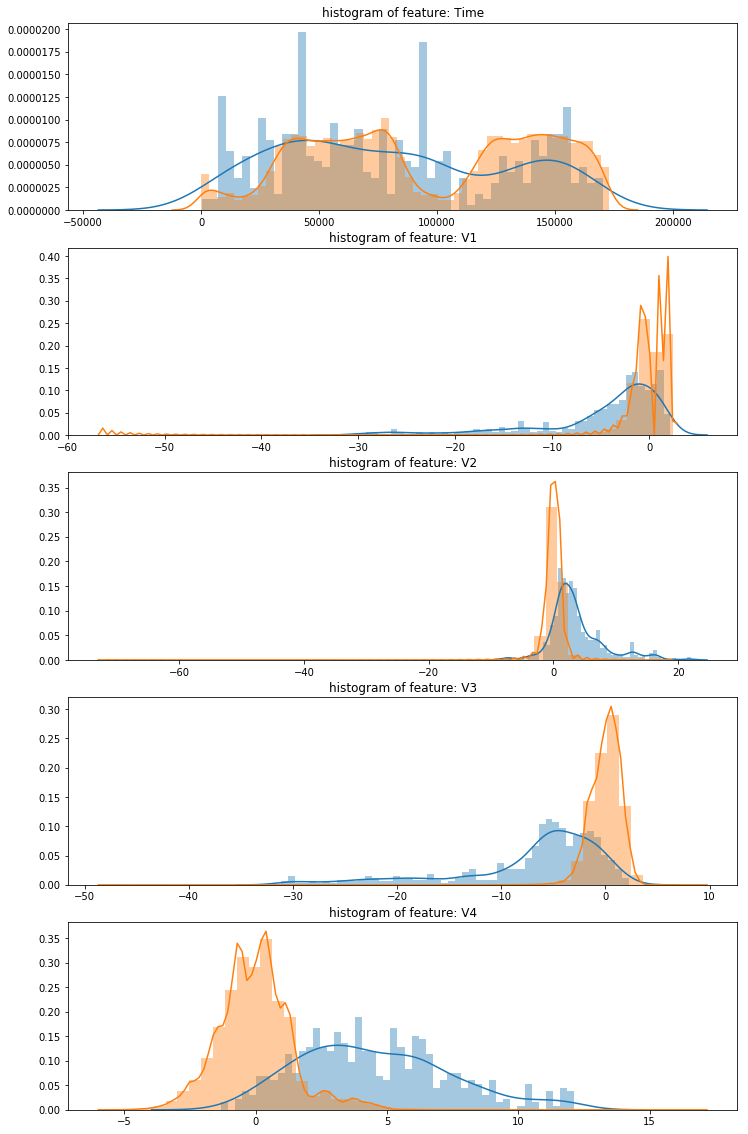

In [20]:
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5, 1)
for i, cn in enumerate(df.columns[:5]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

We graph relative histograms for several of the features for the difference classes. Note there is a pretty significant difference in distribution for fraud v. non-fraud.

### Train/Test Split

We create a train/test split based on the time series, using the first 75% of the transactions as the training set and the following 25% as test set.

In [21]:
TEST_RATIO = 0.25
df.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_y = df.iloc[:TRA_INDEX, -1].values

test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_y = df.iloc[TRA_INDEX:, -1].values

In [22]:
print("Total train examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(train_x.shape[0], np.sum(train_y), np.sum(train_y)/train_x.shape[0]))

Total train examples: 213605, total fraud cases: 398, equal to 0.00186 of total cases. 


In [23]:
print("Total test examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(test_x.shape[0], np.sum(test_y), np.sum(test_y)/test_y.shape[0]))

Total test examples: 71202, total fraud cases: 94, equal to 0.00132 of total cases. 


In order to normalize the data, we use the z-score which is useful for tanh activation for autoencoders.

In [24]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

## Autoencoder

An unsupervised approach is more effective than a supervised approach when we have an imbalance in the classes of training data. Why is that the case?

Imagine we had a training set of 99 true cases and 1 false case. We show this training set to a supervised algorithm and we get 99% accuracy. This seems great until we realize that the model has been trained to output true for all inputs. We haven't fed the model enough false cases for it to create a meaningful distinction.

Contrast this with an unsupervised model, and in particular an autoencoder. The autoencoder will try to approximate the function $f(x) = x$. Essentially, given an input $x$, the network will learn to output $f(x)$ that is close to $x$. The cost function is usually the RMSE, which measures the error between $f(x)$ and $x$.

The architecture of an auto-encoder is very similar to a typical feed-forward model, except the output layer has exactly the same number of neurons as the input layer. 

The autoencoder will learn the common patterns of the data. When we feed the autoencoder data that doesn't conform to these patterns, the RMSE will be above a threshold that we set and we can mark it as being an anomaly. These anomalies will be our best guesses for fraudlent cases.

One advantage for this approach is that fraudlent cases can adapt in the future. However, since the model is unsupervised, it just needs to learn what is `normal` as oppposed to explicitly learning what is `non-normal`.

In [25]:
# Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 256
display_step = 1

# Network Parameters
n_hidden_1 = 15 # 1st layer num features
#n_hidden_2 = 15 # 2nd layer num features
n_input = train_x.shape[1] # MNIST data input (img shape: 28*28)
data_dir = '.'

In [26]:
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    #'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    #'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   #biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                  # biases['decoder_b2']))
    return layer_1

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# TRAIN StARTS
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_x.shape[0], batch_size)
            batch_xs = train_x[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            train_batch_mse = sess.run(batch_mse, feed_dict={X: train_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Train auc=", "{:.6f}".format(auc(train_y, train_batch_mse)), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)

Epoch: 0001 cost= 1.095862985 Train auc= 0.949134 Time elapsed= 0:00:00.947033
Epoch: 0002 cost= 0.747021258 Train auc= 0.949555 Time elapsed= 0:00:01.760408
Epoch: 0003 cost= 0.772427678 Train auc= 0.953609 Time elapsed= 0:00:02.665170
Epoch: 0004 cost= 0.791222036 Train auc= 0.955763 Time elapsed= 0:00:03.648197
Epoch: 0005 cost= 0.400741339 Train auc= 0.957194 Time elapsed= 0:00:04.517115
Epoch: 0006 cost= 0.624367774 Train auc= 0.956906 Time elapsed= 0:00:05.410418
Epoch: 0007 cost= 0.354475975 Train auc= 0.956978 Time elapsed= 0:00:06.239724
Epoch: 0008 cost= 0.388548106 Train auc= 0.957056 Time elapsed= 0:00:07.076691
Epoch: 0009 cost= 0.330522597 Train auc= 0.956237 Time elapsed= 0:00:07.956003
Epoch: 0010 cost= 0.531045139 Train auc= 0.955071 Time elapsed= 0:00:08.832857
Optimization Finished!
Model saved in file: ./temp_saved_model_1layer.ckpt


### Test Model

In [28]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse = sess.run(batch_mse, feed_dict={X: test_x})
    
    print("Test auc score: {:.6f}".format(auc(test_y, test_batch_mse)))

INFO:tensorflow:Restoring parameters from ./temp_saved_model_1layer.ckpt
Test auc score: 0.952086


### Visualize the Prediction

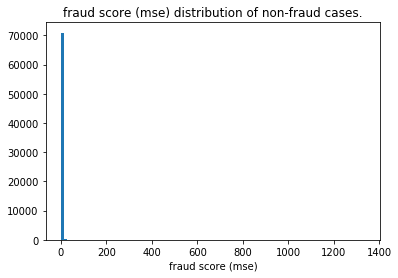

In [29]:
plt.hist(test_batch_mse[test_y == 0.0], bins = 100)
plt.title("fraud score (mse) distribution of non-fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

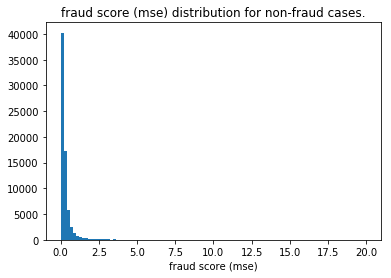

In [30]:
plt.hist(test_batch_mse[(test_y == 0.0) & (test_batch_mse < 20)], bins = 100)
plt.title("fraud score (mse) distribution for non-fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

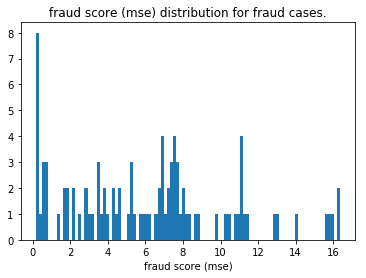

In [31]:
plt.hist(test_batch_mse[test_y == 1.0], bins = 100)
plt.title("fraud score (mse) distribution for fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

Notice that the MSE scores for fraudlent cases is much higher (and more distributed) than the MSE scores for non-fraud cases.